# snmC Mapping Summary

This notebook provides a quick overview of some key mapping metrics. You can customize it by yourself.

[**See documentation about mapping metrics here.**](https://app.gitbook.com/@hq-1/s/mc/mapping-summary-and-metrics)

## Parameters

## Prepare

In [1]:
output_dir = ''
plate_col = 'Plate'
color_quantile = (0.025, 0.975)

In [2]:
# Parameters
output_dir = "/project/spott/qiaoshan/scNOMe-seq/test/mapping"


### Load

In [3]:
import pathlib
import pandas as pd
from cemba_data.utilities import get_configuration

output_dir = pathlib.Path(output_dir)
mapping_summary = pd.read_csv(output_dir / 'stats/MappingSummary.csv.gz', index_col=0)
config = get_configuration(output_dir / 'mapping_config.ini')

In [4]:
mapping_summary.columns

Index(['Plate', 'PCRIndex', 'MultiplexGroup', 'RandomIndex', 'Col384',
       'Row384', 'R1InputReads', 'R1InputReadsBP', 'R1WithAdapters',
       'R1QualTrimBP', 'R1TrimmedReads', 'R1TrimmedReadsBP',
       'R1TrimmedReadsRate', 'R1UniqueMappedReads', 'R1MappingRate',
       'R1UnmappedReads', 'R1UnuniqueMappedReads', 'R1OT', 'R1OB', 'R1CTOT',
       'R1CTOB', 'R1TotalC', 'R1TotalmCGRate', 'R1TotalmCHGRate',
       'R1TotalmCHHRate', 'R1MAPQFilteredReads', 'R1DuplicatedReads',
       'R1DuplicationRate', 'R1FinalBismarkReads', 'R2InputReads',
       'R2InputReadsBP', 'R2WithAdapters', 'R2QualTrimBP', 'R2TrimmedReads',
       'R2TrimmedReadsBP', 'R2TrimmedReadsRate', 'R2UniqueMappedReads',
       'R2MappingRate', 'R2UnmappedReads', 'R2UnuniqueMappedReads', 'R2OT',
       'R2OB', 'R2CTOT', 'R2CTOB', 'R2TotalC', 'R2TotalmCGRate',
       'R2TotalmCHGRate', 'R2TotalmCHHRate', 'R2MAPQFilteredReads',
       'R2DuplicatedReads', 'R2DuplicationRate', 'R2FinalBismarkReads',
       'mCHmC', 'mCH

### Plot

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from cemba_data.mapping import cutoff_vs_cell_remain, plot_on_plate


def distplot_and_plate_view(data, hue, color_quantile=color_quantile, config=config):
    fig1, (vmin, vmax) = cutoff_vs_cell_remain(data=data[hue].dropna(), 
                                               bins=50, kde=False,
                                               xlim_quantile=color_quantile)

    fig2, plate_names, plate_datas = plot_on_plate(
        data=data,
        hue=hue,
        groupby=plate_col,
        vmin=vmin,
        vmax=vmax,
        aggregation_func=lambda i: i.mean())
    
    fig3, ax = plt.subplots(figsize=(data[plate_col].unique().size * 2, 4))
    plate_hue_name = 'MultiplexGroup' if config['barcode_version'] == 'V2' else 'RandomIndex'
    sns.boxenplot(data=data, x=plate_col, y=hue, palette='hls', 
                  ax=ax, hue=plate_hue_name)
    ax.set_ylim(vmin, vmax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.legend(bbox_to_anchor=(1.1, 1), title=plate_hue_name)
    sns.despine(ax=ax)
    return

In [6]:
# plot defaults
sns.set_context(context='notebook')
plt.rc('figure', dpi=150)

## Summary

In [7]:
# conventional basic check, change as you need
mccc_cutoff = 0.03
high_mccc = mapping_summary['mCCCFrac'] > mccc_cutoff

miseq_guess = mapping_summary['FinalmCReads'].mean() < 50000
reads_cutoff = 100 if miseq_guess else 500000
low_reads = mapping_summary['FinalmCReads'] < reads_cutoff

success = ~high_mccc & ~low_reads
n_cell = mapping_summary.shape[0]
n_plate = mapping_summary['Plate'].unique().size
total_wells = n_plate * 384

In [8]:
print(f"""
This library seems to be a {'MiSeq' if miseq_guess else 'NovaSeq'} library.

Cells
    {n_plate}\t plates
    {total_wells}\t wells (total cell number in theory)

    {n_cell} ({n_cell / total_wells * 100:.1f}%)\t cells having mapping metric
    {success.sum()} ({success.sum() / total_wells * 100:.1f}%)\t cells passed basic QC (mCCC and # of final reads)
    {high_mccc.sum()} ({high_mccc.sum() / total_wells * 100:.1f}%)\tcells having high mCCC frac (> {mccc_cutoff})
    {low_reads.sum()} ({low_reads.sum() / total_wells * 100:.1f}%)\tcells having low number of final mC reads (< {reads_cutoff}).

Reads
    {mapping_summary['CellInputReadPairs'].sum()*2:.0f}\tTotal Input Reads (R1 & R2)
    {mapping_summary['CellInputReadPairs'].mean()*2:.0f}\tAverage Input Reads for cells having metric (R1 & R2)
    {mapping_summary['FinalmCReads'].sum():.0f}\tTotal Final Reads (R1 & R2)
    {mapping_summary['FinalmCReads'].mean():.0f}\tAverage Final Reads for cells having metric (R1 & R2)

    {mapping_summary['R1MappingRate'].mean():.1f}%\tAverage R1 Mapping Rate for cells having metric
    {mapping_summary['R2MappingRate'].mean():.1f}%\tAverage R2 Mapping Rate for cells having metric
    {mapping_summary['R1DuplicationRate'].mean() * 100:.1f}%\tAverage R1 PCR Duplicate Rate for cells having metric
    {mapping_summary['R2DuplicationRate'].mean() * 100:.1f}%\tAverage R2 PCR Duplicate Rate for cells having metric
""")


This library seems to be a MiSeq library.

Cells
    1	 plates
    384	 wells (total cell number in theory)

    63 (16.4%)	 cells having mapping metric
    62 (16.1%)	 cells passed basic QC (mCCC and # of final reads)
    0 (0.0%)	cells having high mCCC frac (> 0.03)
    1 (0.3%)	cells having low number of final mC reads (< 100).

Reads
    42246	Total Input Reads (R1 & R2)
    671	Average Input Reads for cells having metric (R1 & R2)
    22742	Total Final Reads (R1 & R2)
    361	Average Final Reads for cells having metric (R1 & R2)

    70.9%	Average R1 Mapping Rate for cells having metric
    57.0%	Average R2 Mapping Rate for cells having metric
    0.2%	Average R1 PCR Duplicate Rate for cells having metric
    0.1%	Average R2 PCR Duplicate Rate for cells having metric



## Final mC Reads

/project/spott/software/miniconda3/envs/yap/lib/python3.7/site-packages/cemba_data/mapping/stats/plot.py:142: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(data, bins=bins, kde=kde, ax=ax1)


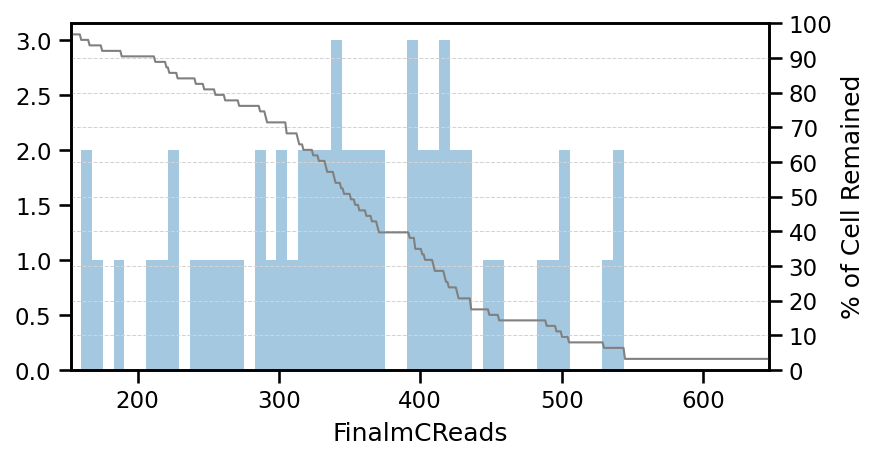

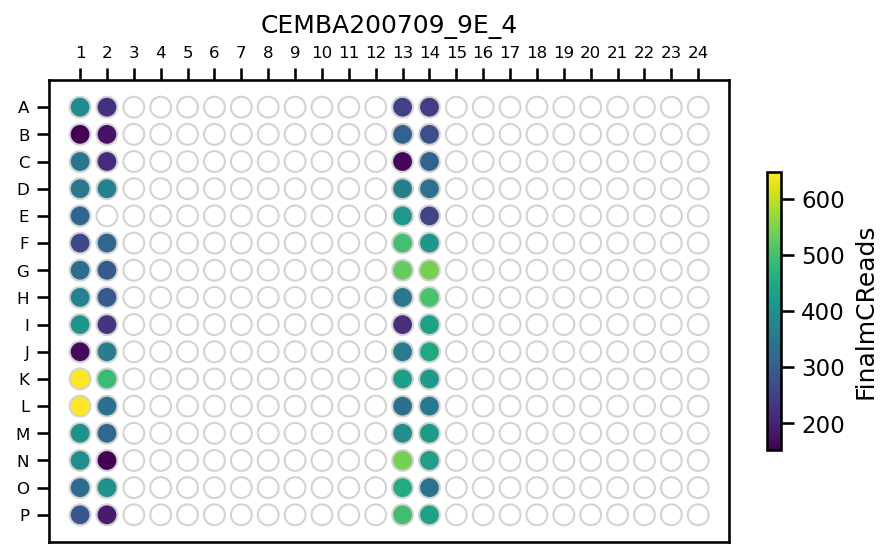

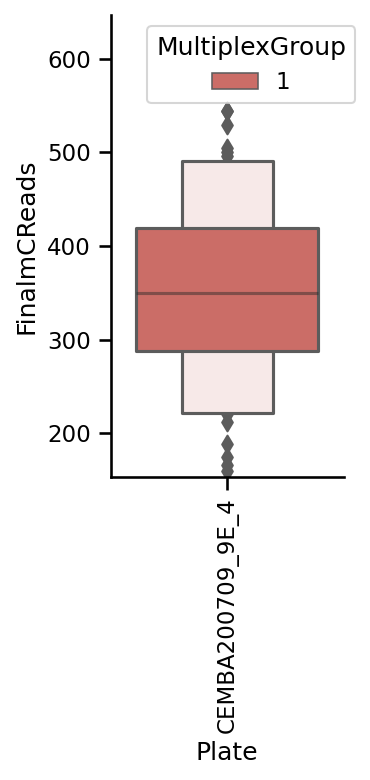

In [9]:
distplot_and_plate_view(mapping_summary, hue='FinalmCReads')

## mC Fraction

### mCCC

/project/spott/software/miniconda3/envs/yap/lib/python3.7/site-packages/cemba_data/mapping/stats/plot.py:142: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(data, bins=bins, kde=kde, ax=ax1)


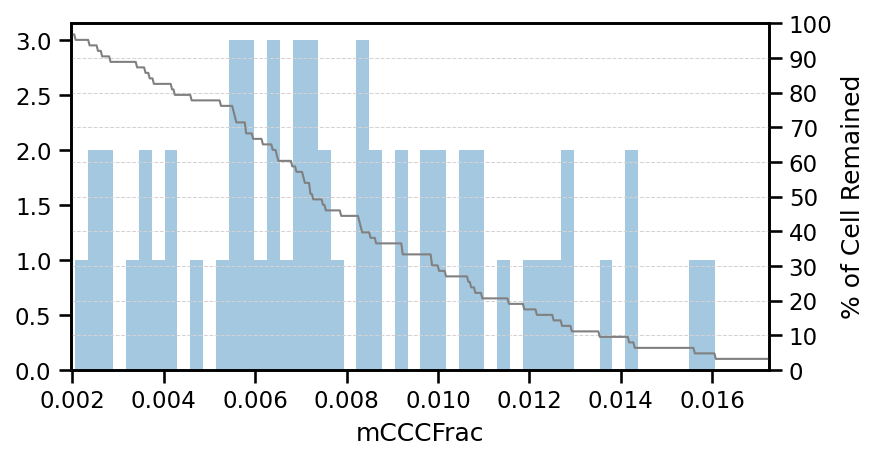

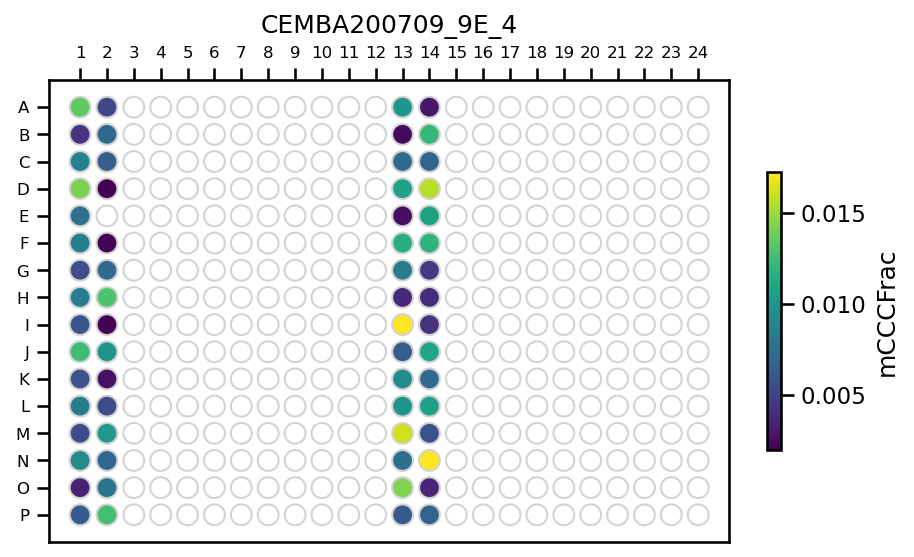

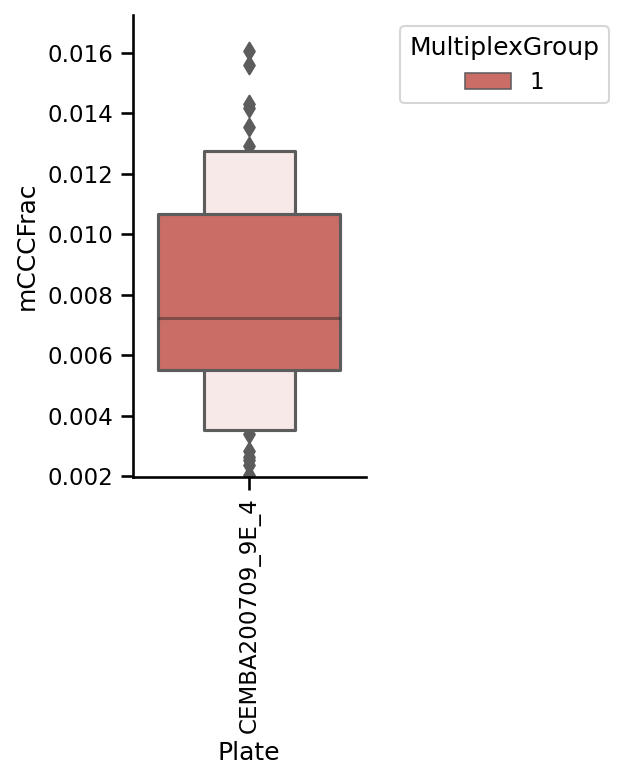

In [10]:
distplot_and_plate_view(mapping_summary, hue='mCCCFrac')

### mCH

/project/spott/software/miniconda3/envs/yap/lib/python3.7/site-packages/cemba_data/mapping/stats/plot.py:142: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(data, bins=bins, kde=kde, ax=ax1)


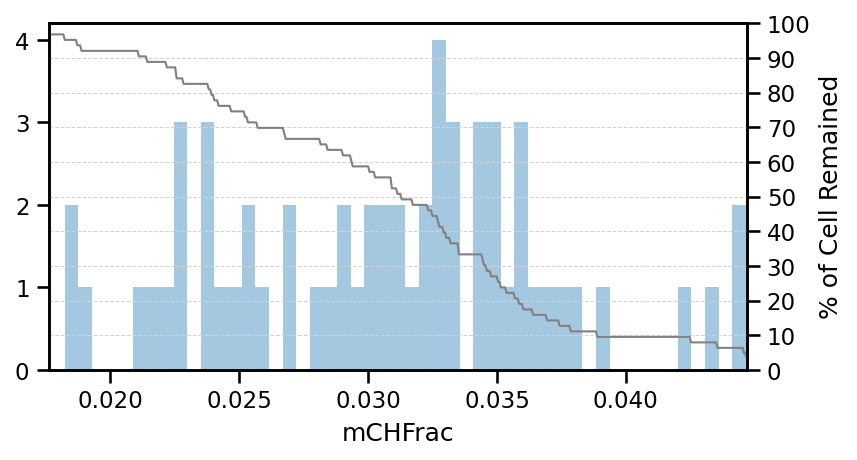

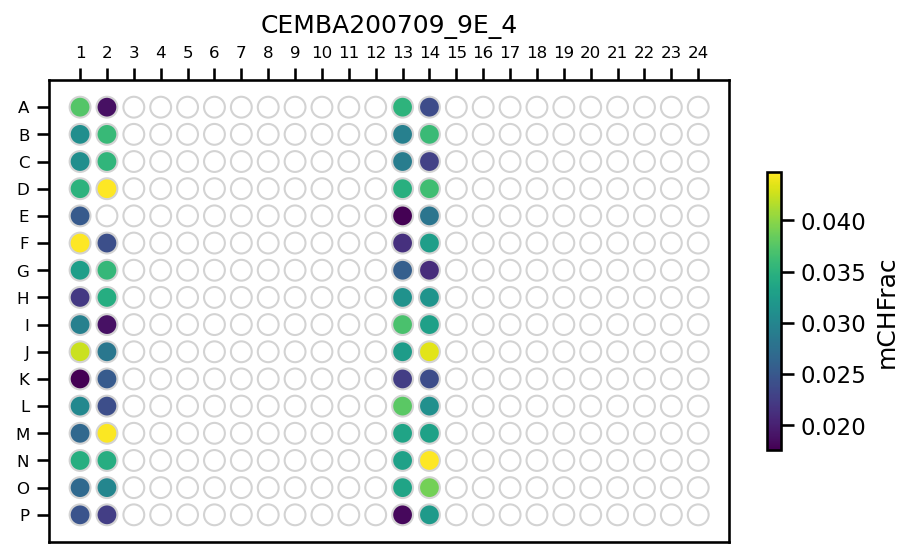

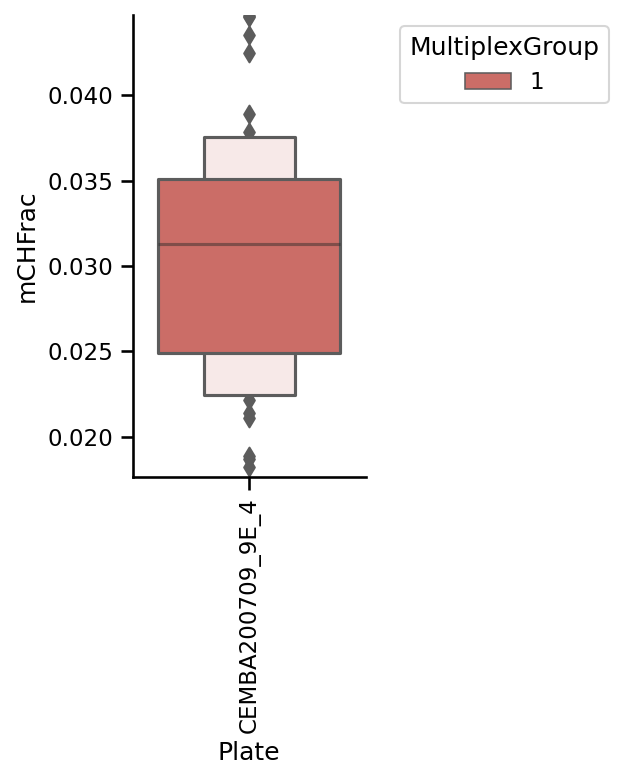

In [11]:
distplot_and_plate_view(mapping_summary, hue='mCHFrac')

### mCG

/project/spott/software/miniconda3/envs/yap/lib/python3.7/site-packages/cemba_data/mapping/stats/plot.py:142: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(data, bins=bins, kde=kde, ax=ax1)


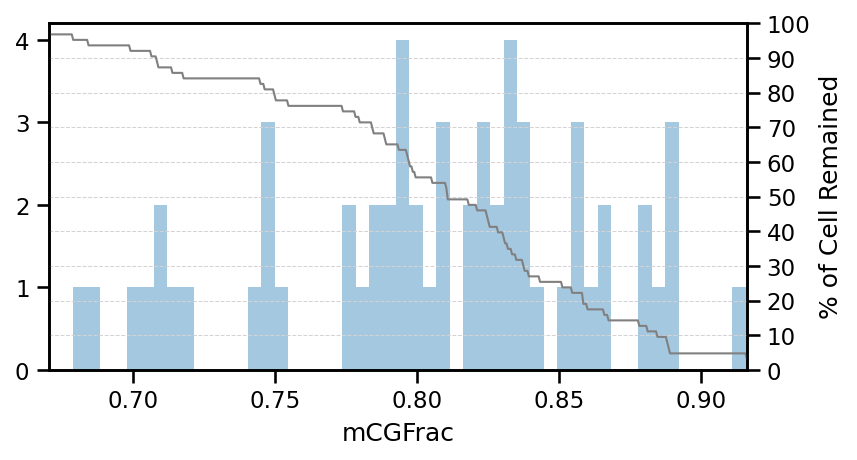

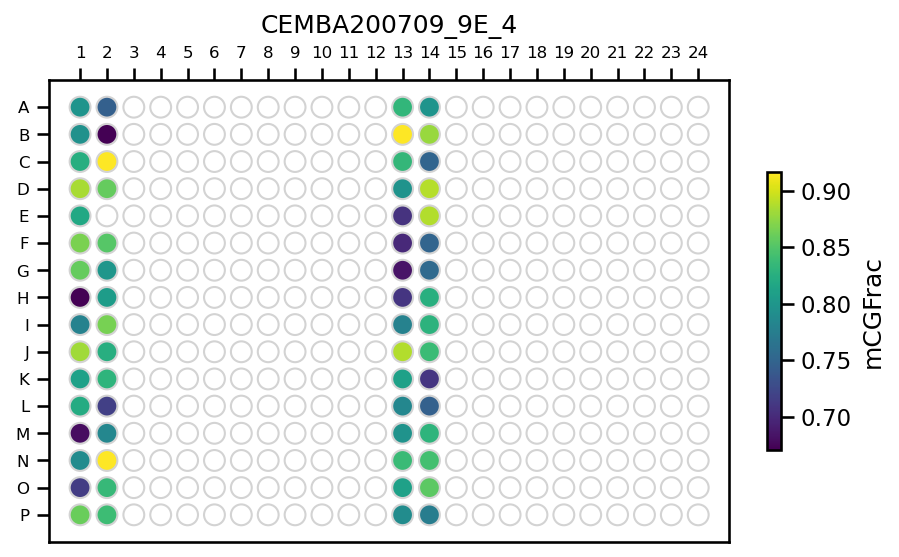

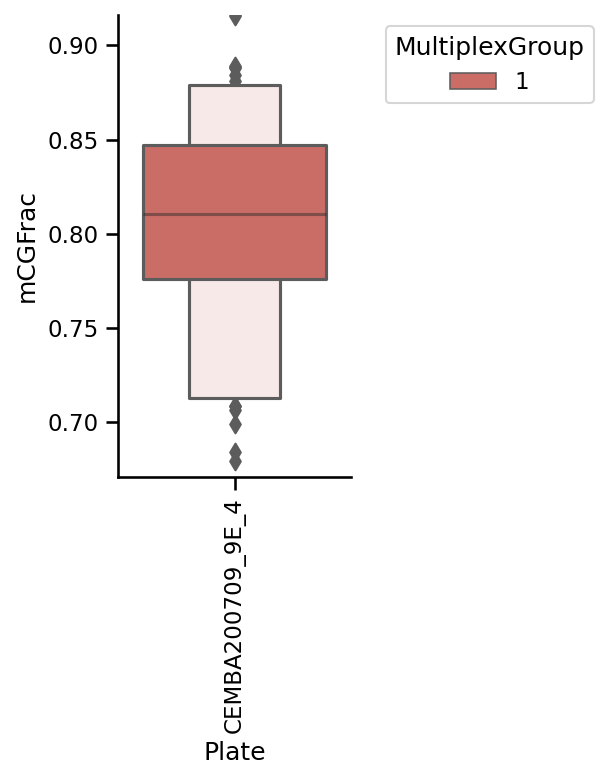

In [12]:
distplot_and_plate_view(mapping_summary, hue='mCGFrac')

## FASTQ Metric

### CellInputReadPairs

/project/spott/software/miniconda3/envs/yap/lib/python3.7/site-packages/cemba_data/mapping/stats/plot.py:142: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(data, bins=bins, kde=kde, ax=ax1)


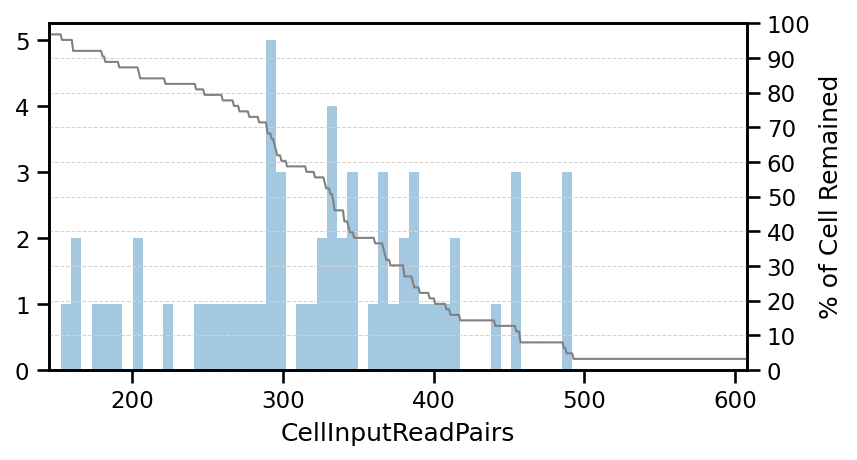

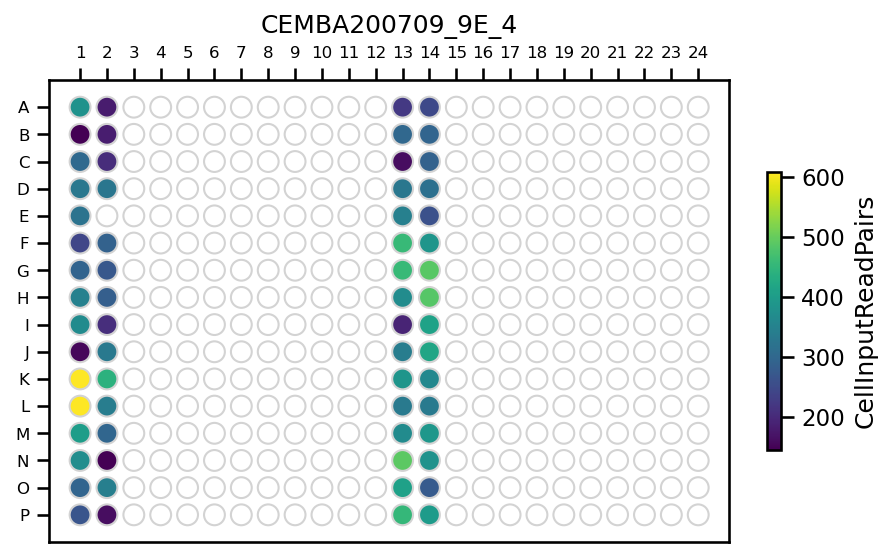

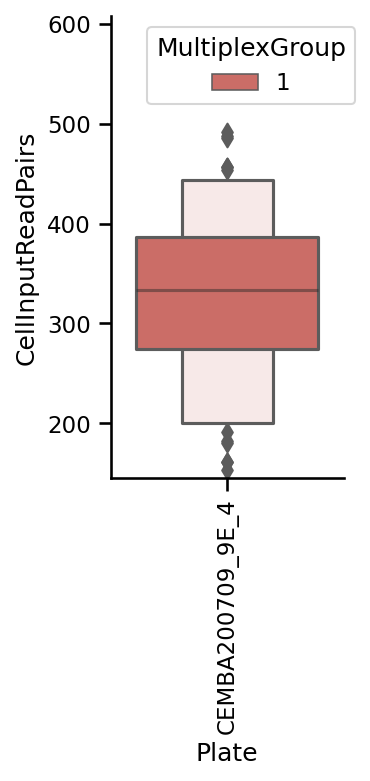

In [13]:
distplot_and_plate_view(mapping_summary, hue='CellInputReadPairs')

## Cell Barcode Portion

/project/spott/software/miniconda3/envs/yap/lib/python3.7/site-packages/cemba_data/mapping/stats/plot.py:142: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(data, bins=bins, kde=kde, ax=ax1)


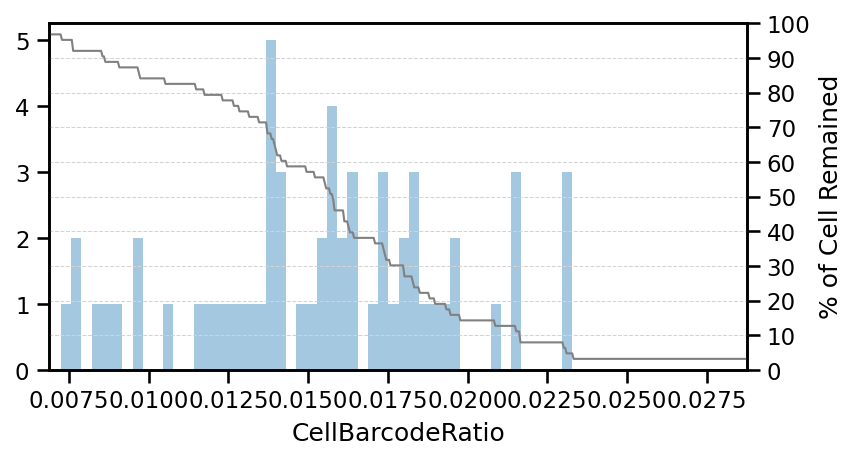

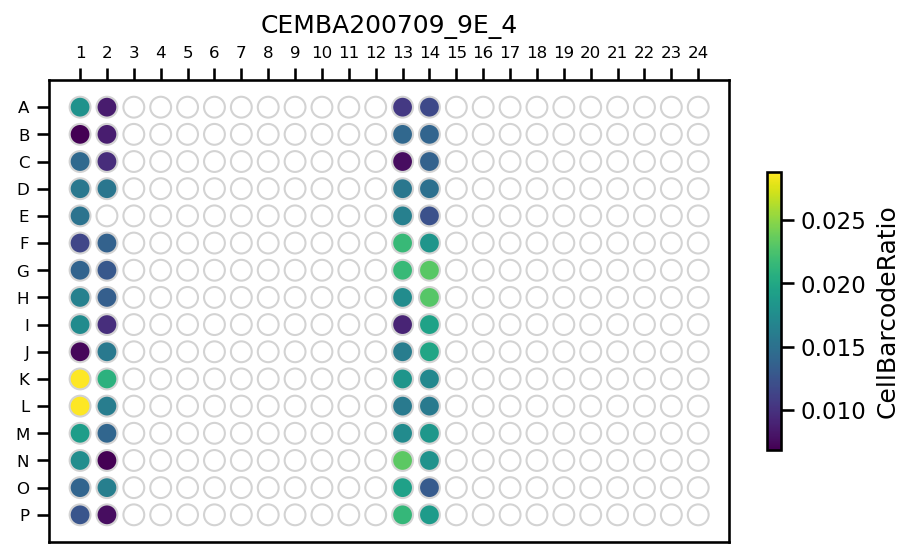

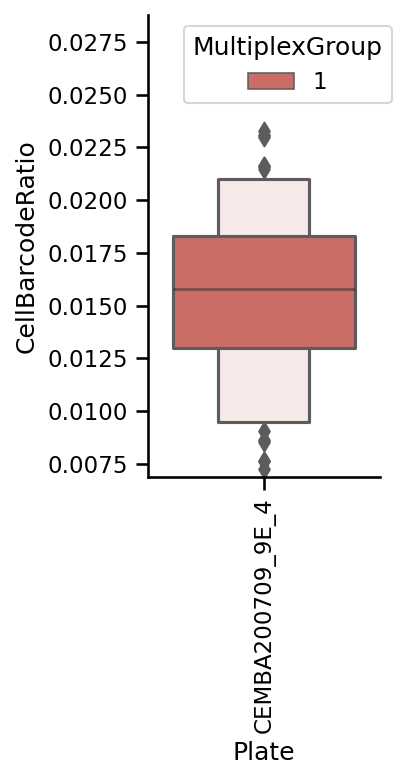

In [14]:
distplot_and_plate_view(mapping_summary, hue='CellBarcodeRatio')

## Mapping Rate

### R1 Mapping Rate

/project/spott/software/miniconda3/envs/yap/lib/python3.7/site-packages/cemba_data/mapping/stats/plot.py:142: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(data, bins=bins, kde=kde, ax=ax1)


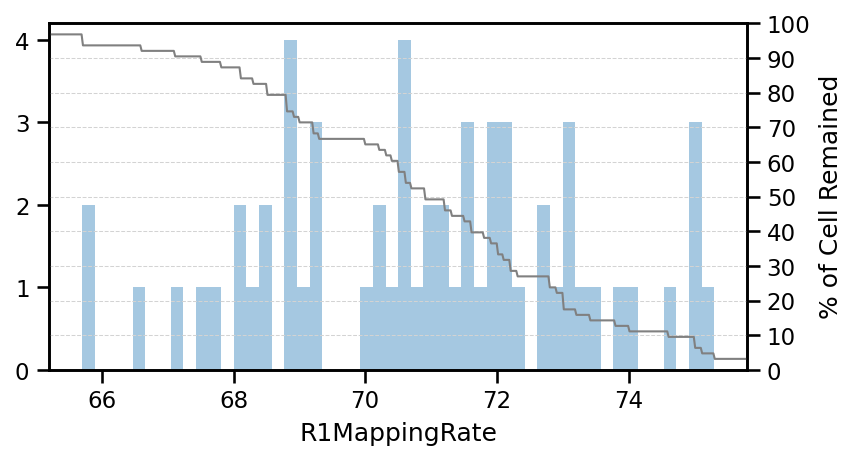

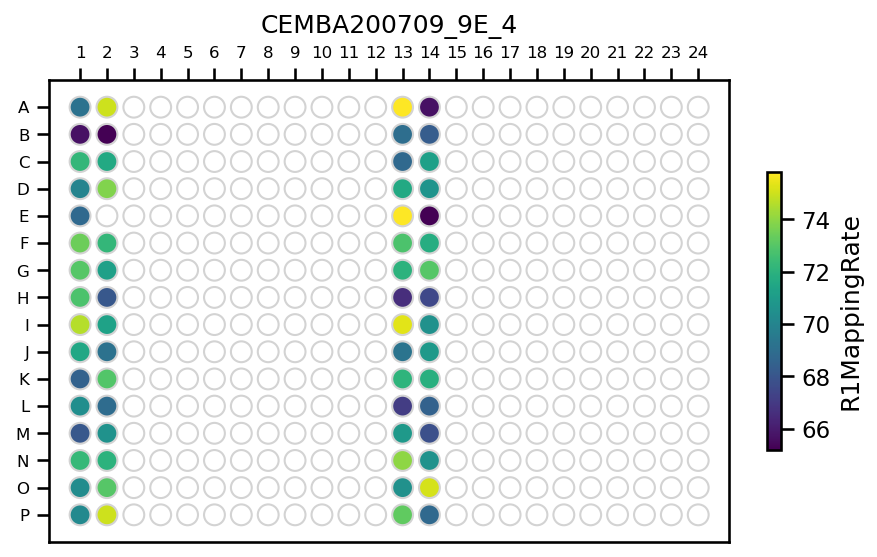

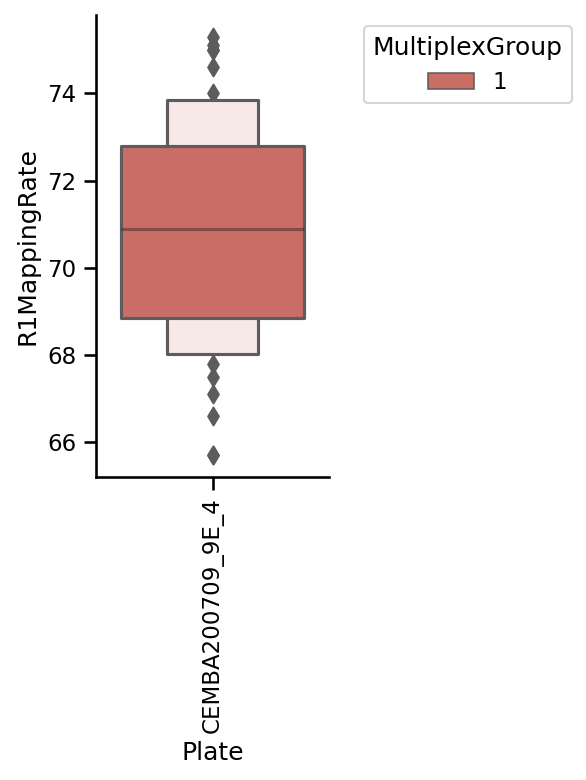

In [15]:
distplot_and_plate_view(mapping_summary, hue='R1MappingRate')

### R2 Mapping Rate

/project/spott/software/miniconda3/envs/yap/lib/python3.7/site-packages/cemba_data/mapping/stats/plot.py:142: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(data, bins=bins, kde=kde, ax=ax1)


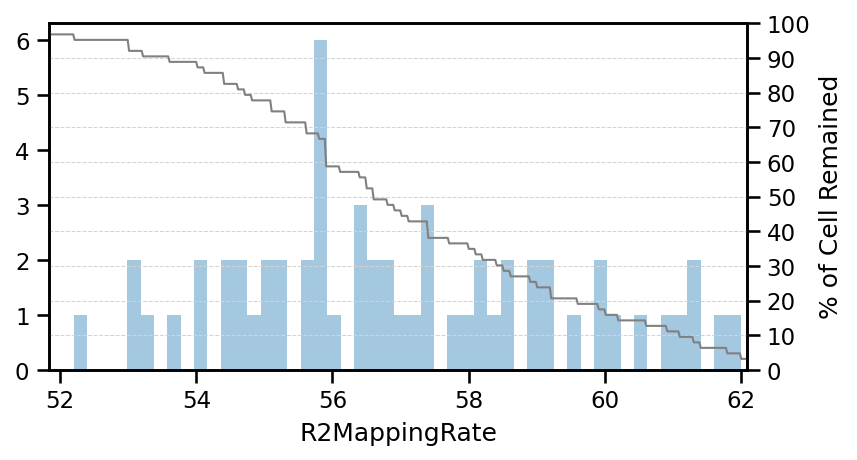

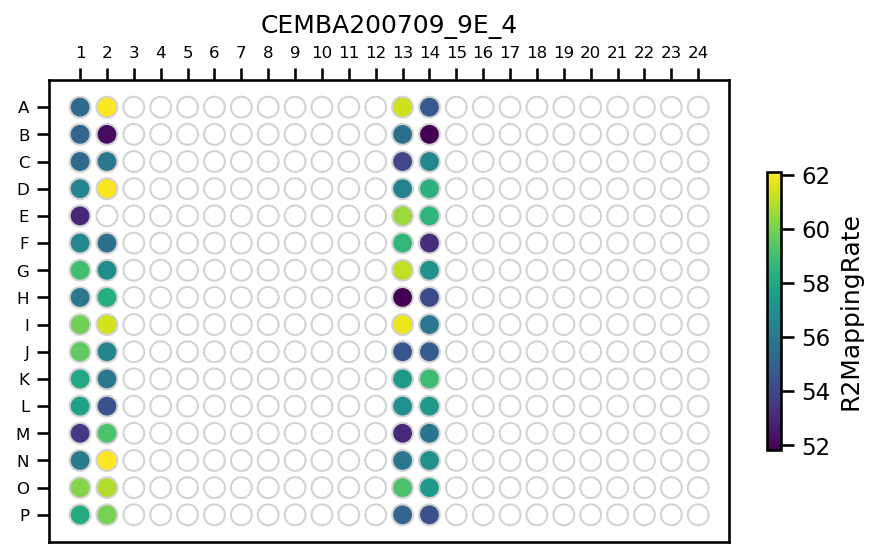

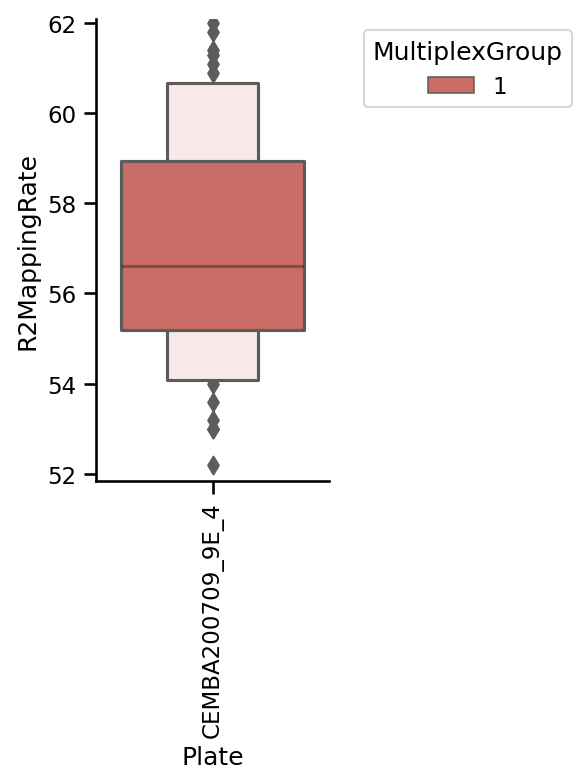

In [16]:
distplot_and_plate_view(mapping_summary, hue='R2MappingRate')

## PCR Duplication Rate

### R1 PCR Duplication Rate

/project/spott/software/miniconda3/envs/yap/lib/python3.7/site-packages/cemba_data/mapping/stats/plot.py:142: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(data, bins=bins, kde=kde, ax=ax1)


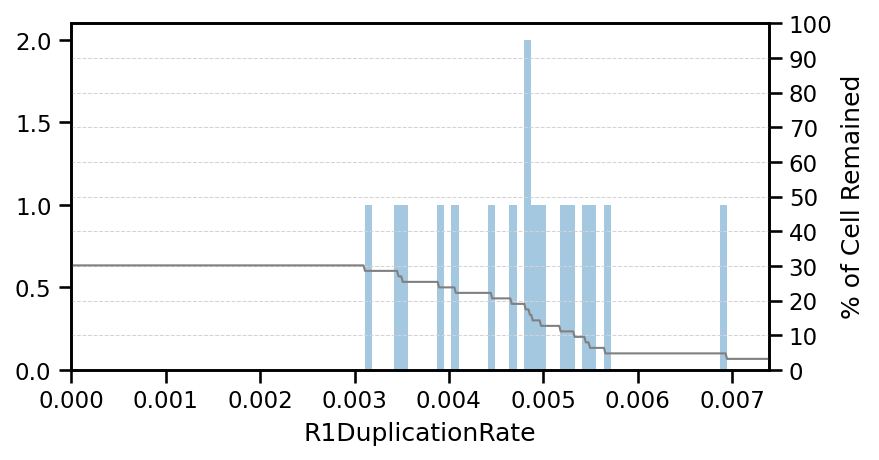

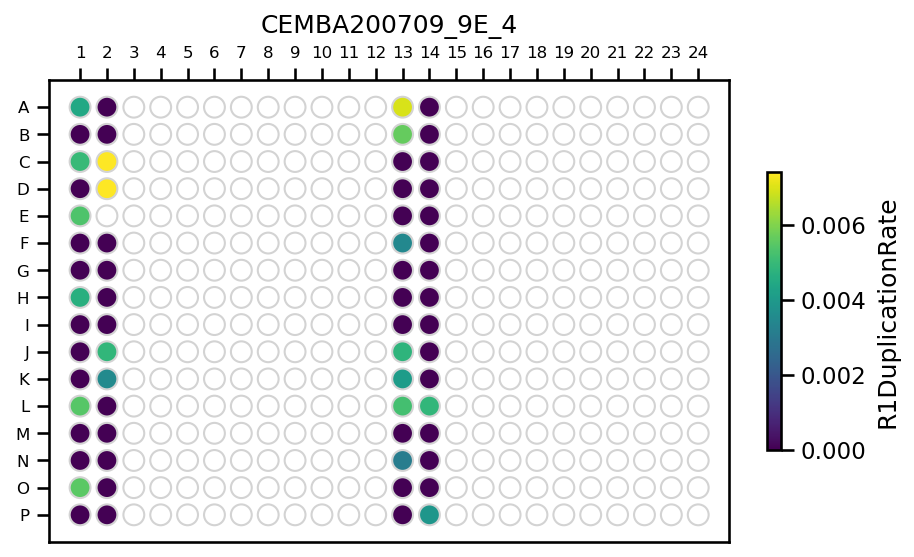

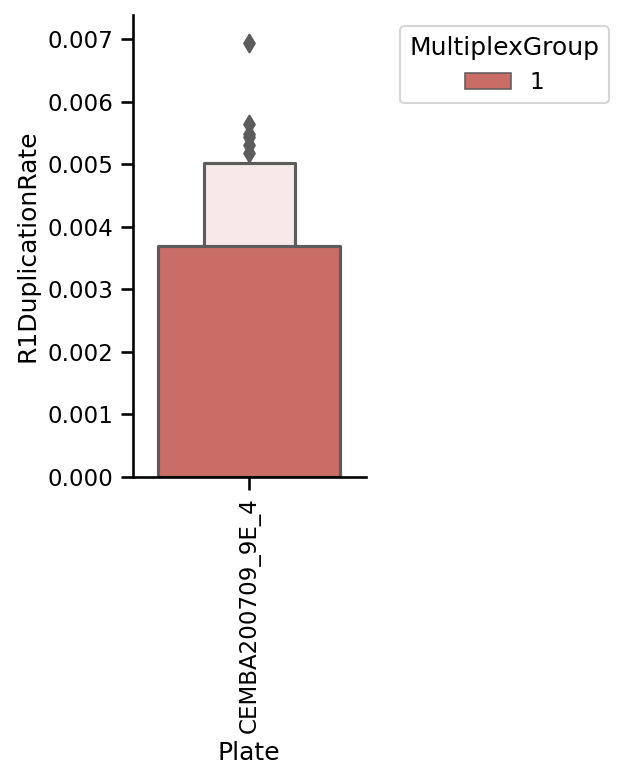

In [17]:
distplot_and_plate_view(mapping_summary, hue='R1DuplicationRate')

### R2 PCR Duplication Rate

/project/spott/software/miniconda3/envs/yap/lib/python3.7/site-packages/cemba_data/mapping/stats/plot.py:142: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(data, bins=bins, kde=kde, ax=ax1)


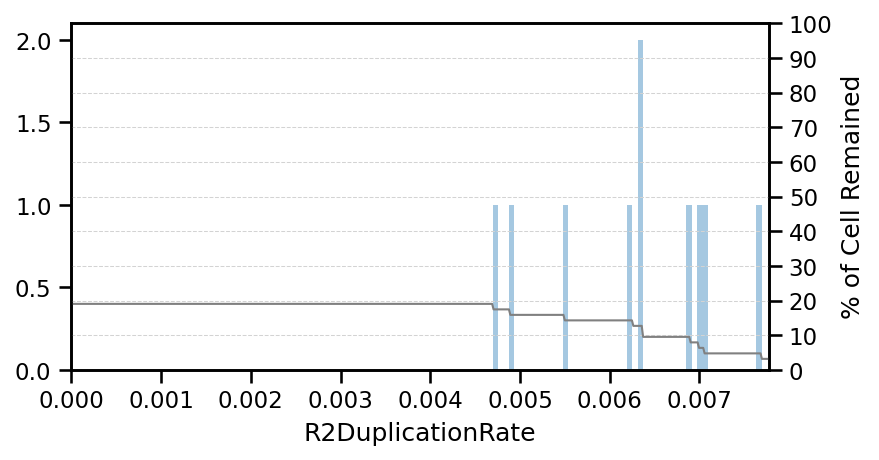

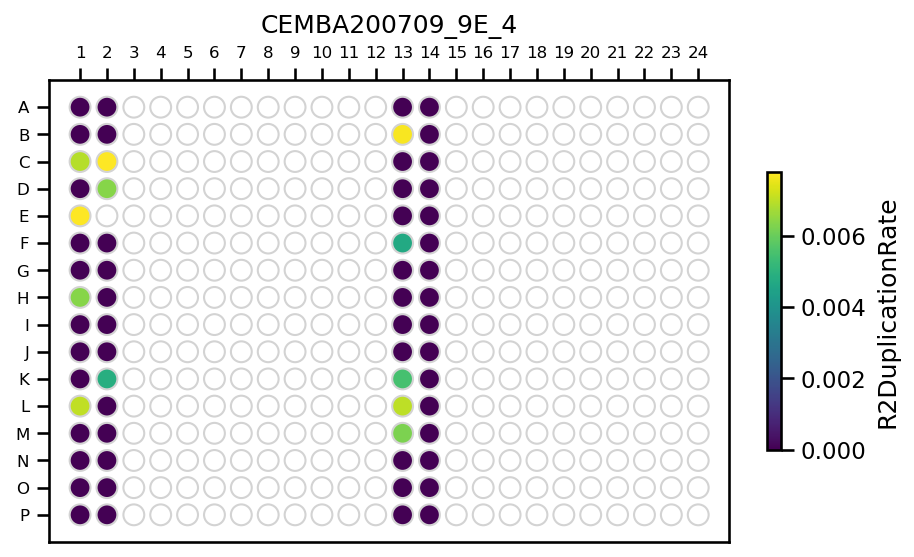

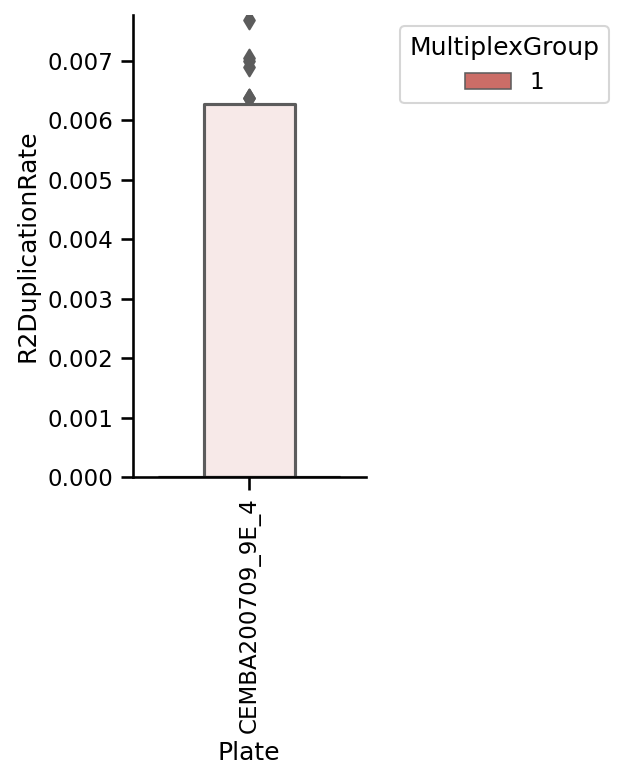

In [18]:
distplot_and_plate_view(mapping_summary, hue='R2DuplicationRate')

## Mapping config

In [19]:
config

{'mode': 'mc',
 'barcode_version': 'V2',
 'r1_adapter': 'AGATCGGAAGAGCACACGTCTGAAC',
 'r2_adapter': 'AGATCGGAAGAGCGTCGTGTAGGGA',
 'overlap': '6',
 'r1_left_cut': '10',
 'r1_right_cut': '10',
 'r2_left_cut': '10',
 'r2_right_cut': '10',
 'quality_threshold': '20',
 'length_threshold': '30',
 'total_read_pairs_min': '1',
 'total_read_pairs_max': '6000000',
 'bismark_reference': '/project/spott/reference/mouse/GRCm39/genome',
 'unmapped_fastq': 'False',
 'mapq_threshold': '10',
 'reference_fasta': '/project/spott/reference/mouse/GRCm39/genome/mm39.fa',
 'num_upstr_bases': '0',
 'num_downstr_bases': '2',
 'compress_level': '5',
 'mc_stat_feature': 'CHN CGN CCC',
 'mc_stat_alias': 'mCH mCG mCCC',
 'chrom_size_path': '/project/spott/reference/mouse/GRCm39/mm39.chrom.sizes'}